# Анализ параметров 3. Приближаем $\gamma$

In [35]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [36]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [37]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [38]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    #def T_r(self):
    #    '''
    #    Кинетическая энергия отнсительнго движения
    #    '''
    #    return self.m_r * np.sum(((self.c_r - self.vel)  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

In [39]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.abs(np.sum(self.s1.c_r * self.s2.c_r, axis = 0)/(self.s1.length_vel() * self.s2.length_vel())))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
        
    def lmbd2(self):
        '''для подсчёта лямбда'''
        return  np.sum(self.s1.T_r()), np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()), np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.mean(self.s1.T_r() / self.s1.Full_Energy_r()),\
                np.mean(self.s2.T_r() / self.s2.Full_Energy_r())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [40]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 1.9, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. косинс угла
     2. lambda до и после
     3. lambda_1 до и после
     4. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            # lambda
            lmbd1, lmbd2 = s.lmbd()
            lmbd1_t, lmbd2_t = s.lmbd_1()
            
            # угол
            angle = s.angle()
            
            # T
            T1,H1,T2,H2 = s.lmbd2()
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['angle'] = [] 
                
                result_v[c_r_i_str]['l1'] = []          
                result_v[c_r_i_str]['l2'] = []             
                result_v[c_r_i_str]['l1_t'] = []          
                result_v[c_r_i_str]['l2_t'] = [] 
                   
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []             
                result_v[c_r_i_str]['T1'] = []          
                result_v[c_r_i_str]['T2'] = [] 
                   
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['angle'] = []
                
                result_b[b_str]['l1'] = []          
                result_b[b_str]['l2'] = []             
                result_b[b_str]['l1_t'] = []          
                result_b[b_str]['l2_t'] = [] 
                
                result_b[b_str]['H1'] = []        
                result_b[b_str]['H2'] = []            
                result_b[b_str]['T1'] = [] 
                result_b[b_str]['T2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['angle'].append(angle)
            result_v[c_r_i_str]['b'].append(b)
            
            result_v[c_r_i_str]['l1'].append(lmbd1)       
            result_v[c_r_i_str]['l2'].append(lmbd2)          
            result_v[c_r_i_str]['l1_t'].append(lmbd1_t)          
            result_v[c_r_i_str]['l2_t'].append(lmbd2_t) 
            
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2)          
            result_v[c_r_i_str]['T1'].append(T1)          
            result_v[c_r_i_str]['T2'].append(T2) 
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['angle'].append(angle)
            
            result_b[b_str]['l1'].append(lmbd1)        
            result_b[b_str]['l2'].append(lmbd2)            
            result_b[b_str]['l1_t'].append(lmbd1_t)    
            result_b[b_str]['l2_t'].append(lmbd2_t)

            result_b[b_str]['H1'].append(H1)        
            result_b[b_str]['H2'].append(H2)            
            result_b[b_str]['T1'].append(T1)    
            result_b[b_str]['T2'].append(T2)
    
    return result_v, result_b

# Подсчёт параметров

In [41]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [42]:
result_v = {}
result_b = {}

v,b = process_full(END_b = 1.9)

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                       END_FILE_NUM=3,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                       END_FILE_NUM=5,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out1/", 
                   END_FILE_NUM=18,
                   START_b = 0.1,
                   END_b = 2.0)
result_v = update(result_v, v)
result_b = update(result_b, b)




#v,b = process_full(PATH="big_vel/", 
#                   END_FILE_NUM=6,
#                   START_b = 1.0,
#                   END_b = 1.7)
#result_v = update(result_v, v)
#result_b = update(result_b, b)

100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


In [273]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Приближаемый параметр $\gamma$


$$
\gamma = \frac{\frac{m_r}{2} (c_r^2 - {c'}_r^2)}{H_r} = \frac{T_r - T_r'}{H_r} = \lambda_{init} - \lambda_{end} 
$$

$$
\lambda = \frac{\sum E_r}{\sum H}
$$

Попробуем предсказывать параметр $\gamma$ от $b(c_r)$ с помощью кусочной функции:
1. $c_r$ больше $c_r$ max, тогда $\gamma = 0$;
2. $c_r$ меньше $c_r$ max и $b > b_{border}$, $\gamma = k_1 \cdot b + t_1$ где $k_1$ и $\gamma_0$ -- функции первой и второй степени от b соответственно, $t = -k \cdot \gamma_0$;
3. $c_r$ меньше $c_r$ max и $b \le b_{border}$, $\gamma = k_2 \cdot b + t_2$, где $k_2$ и $\gamma_0$ -- функции третей степени от b , $t = -k \cdot \gamma_0$;



### Найдём максимальные $c_r$ для каждого $b$ (после которого $\gamma = 0$)

In [382]:
def get_best_c():
    best_c = {}
    for b_i in sorted(result_b.keys()):
        for ind, isPass in enumerate((np.abs(result_b[b_i]['l2'] - result_b[b_i]['l1']) < 1e-3)[::-1]):
            if not isPass:
                break

        if (ind == 0):
            continue
        best_c[float(b_i)] = result_b[b_i]['v'][::-1][ind]
    return best_c

best_c = get_best_c()

def get_best_lmbd():
    best_l = {}
    for b_i in sorted(result_b.keys()):
        for ind, isPass in enumerate((np.abs(result_b[b_i]['l2'] - result_b[b_i]['l1']) < 1e-3)[::-1]):
            if not isPass:
                break

        if (ind == 0):
            continue
        best_l[float(b_i)] = result_b[b_i]['l1'][::-1][ind]
    return best_l

best_c = get_best_c()
best_l = get_best_lmbd()

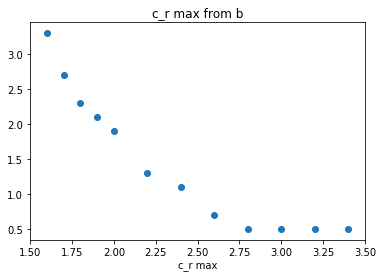

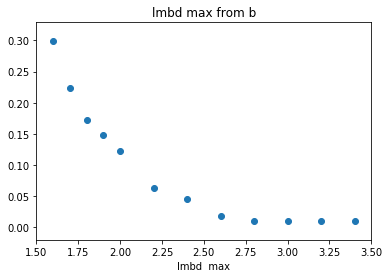

In [383]:
plt.scatter(best_c.keys(), best_c.values())
plt.xlabel("b")
plt.xlabel("c_r max")
plt.title("c_r max from b")
plt.show()

plt.scatter(best_l.keys(), best_l.values())
plt.xlabel("b")
plt.xlabel("lmbd  max")
plt.title("lmbd max from b")
plt.show()

In [384]:
#функция, возвращающая для конкретного b необходимый с_max

def check_c(b):
    global best_c
    b = float(b)
    if b < np.min(best_c.keys()):
        return np.inf
    
    if b > np.max(best_c.keys()):
        return 0.0
    
    keys = sorted(best_c.keys())
    for ind, key in enumerate(keys[:-1]):
        delta = (keys[ind+1] - keys[ind])/2.
        if b < keys[ind+1] - delta:
            return best_c[key]
        
#функция, возвращающая для конкретного b необходимый lmbd_max

def check_l(b):
    global best_l
    b = float(b)
    if b < np.min(best_l.keys()):
        return np.inf
    
    if b > np.max(best_l.keys()):
        return 0.0
    
    keys = sorted(best_l.keys())
    for ind, key in enumerate(keys[:-1]):
        delta = (keys[ind+1] - keys[ind])/2.
        if b < keys[ind+1] - delta:
            return best_l[key]

In [385]:
# поиска индекса максимального значения

def index(max_c, arr):
    for ind, el in enumerate(arr[:-1]):
        if max_c < arr[ind+1]:
            return ind 
    return ind 

### Посчитаем необходимые параметры $k$ и $\gamma_0 = g$

соберём параметры для обучения

In [402]:
k,g, bs = [], [], []
for b in sorted(result_b.keys()):
    max_c = check_c(b)
    x,y = [], []
    if max_c is np.inf:
        x = result_b[b]['l1'] 
        y = result_b[b]["l1"] - result_b[b]["l2"]
    if max_c > 0. and max_c < np.inf:
        border = index(max_c, result_b[b]["v"])
        x = result_b[b]['l1'][:border]
        y = result_b[b]["l1"][:border] - result_b[b]["l2"][:border] 
    
    #if x is None:
        # значит b привысил допустимые значения для взаимодействия
    #    continue
        
    if len(x) > 1:
        plt.show()
        fit = np.polyfit(x,y,1)
        k.append(fit[0])
        g.append(- fit[1] / fit[0])
        bs.append(float(b))
    else:
        best_l[float(b)] = 0#result_b[b]["l1"][0]
        best_c[float(b)] = 0#result_b[b]["v"][0]
        print b, max_c, check_l(b), x, border, result_b[b]["l1"][border]

2.6 0.5000000299743046 0 [] 0 0.00970089308680927
2.8 0.50000001519099 0 [] 0 0.009699667689871662
3.0 0.5000000094687874 0 [] 0 0.009713485367616986
3.2 0.5000000118212027 0 [] 0 0.009775676592902835
3.4 None None [] 0 0.009689778759347609


In [403]:
best_c

{1.6: 3.299999995852683,
 1.7: 2.6999999947098834,
 1.8: 2.2999999860800644,
 1.9: 2.0999999996217733,
 2.0: 1.8999999998243897,
 2.2: 1.2999999912173739,
 2.4: 1.1000000249286572,
 2.6: 0,
 2.8: 0,
 3.0: 0,
 3.2: 0,
 3.4: 0}

Посмотрим, что собрали то, что нужно

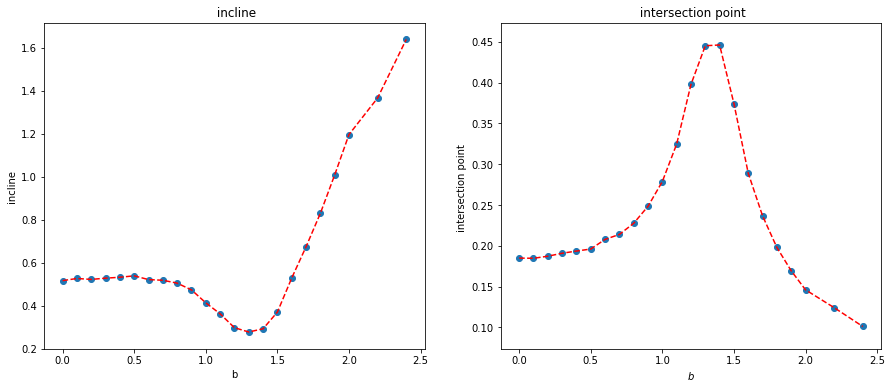

In [404]:

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(bs, k)
plt.plot(bs, k, 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(bs, g)
plt.plot(bs, g, 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')

plt.show()

Определим границу $b_{border}$

In [405]:
border = np.argmin(k) + 1
b_border = bs[border]

### приблизим половину с $b < b_{border}$

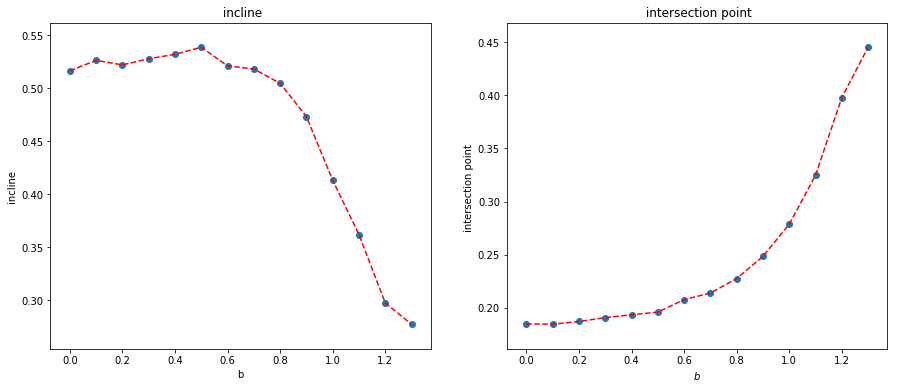

In [406]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(bs[:border], k[:border])
plt.plot(bs[:border], k[:border], 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(bs[:border], g[:border])
plt.plot(bs[:border], g[:border], 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')
plt.show()

#### Приблизим $k$ и $\gamma_0$  функциями 3-й степени

In [407]:
fit_k1 = np.polyfit(bs[:border],k[:border],3)
fit_g1 = np.polyfit(bs[:border],g[:border],3)

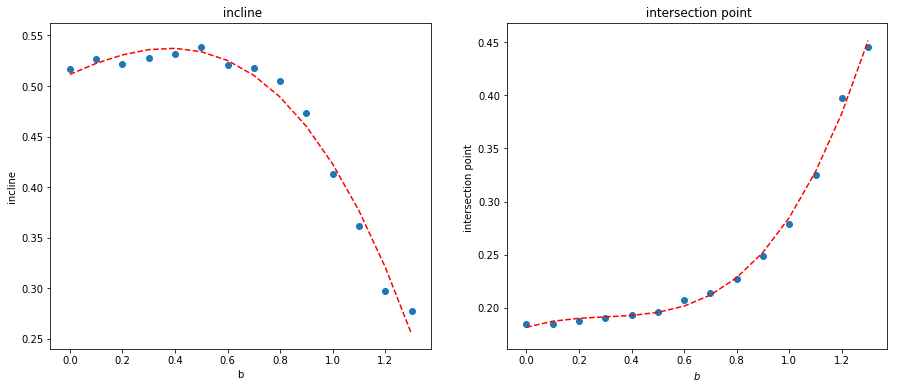

In [408]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(bs[:border], k[:border], label = "real")
fit_fn = np.poly1d(fit_k1) 
plt.plot(bs[:border], fit_fn(bs[:border]), 'r--', label = "predicted")
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(bs[:border], g[:border], label = "real")
fit_fn = np.poly1d(fit_g1) 
plt.plot(bs[:border], fit_fn(bs[:border]), 'r--', label = "predicted")


plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')
plt.show()

### приблизим половину с $b \ge b_{border}$

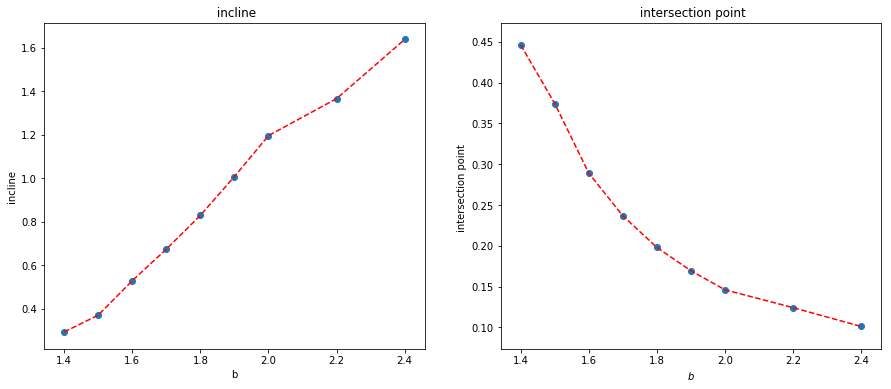

In [409]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(bs[border:], k[border:])
plt.plot(bs[border:], k[border:], 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(bs[border:], g[border:])
plt.plot(bs[border:], g[border:], 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')
plt.show()

In [410]:
len(k), len(g)

(23, 23)

#### Приблизим $k$ и $\gamma_0$  функциями 1-й и 2-й степени соответственно

In [411]:
fit_k2 = np.polyfit(bs[border:],k[border:],1)
fit_g2 = np.polyfit(bs[border:],g[border:],3)

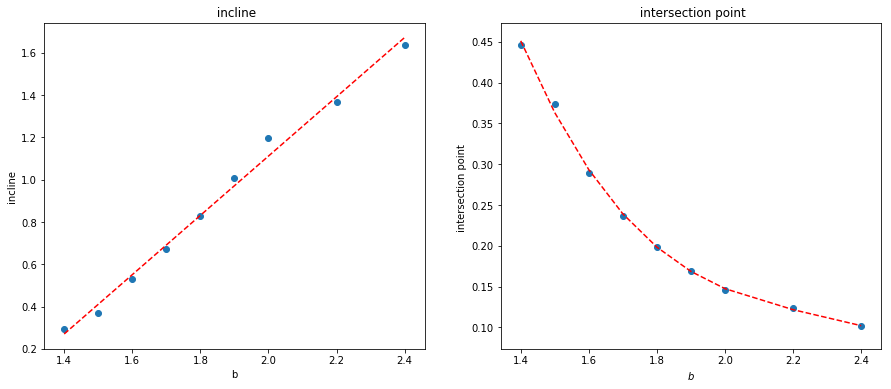

In [412]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.scatter(bs[border:], k[border:])
fit_fn = np.poly1d(fit_k2) 
plt.plot(bs[border:], fit_fn(bs[border:]), 'r--', label = "predicted")

plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(bs[border:], g[border:])
fit_fn = np.poly1d(fit_g2) 
plt.plot(bs[border:], fit_fn(bs[border:]), 'r--', label = "predicted")
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')
plt.show()



In [413]:
print "Получили функции:"
print "При b < border"
print "k(b) = %0.2lf b^3 +%0.2lf b^2 +%0.2lf b + %0.2lf"%(fit_k1[0], fit_k1[1], fit_k1[2], fit_k1[3] )
print "g(b) = %0.2lf b^3 +%0.2lf b^2 +%0.2lf b + %0.2lf"%(fit_g1[0], fit_g1[1], fit_g1[2], fit_g1[3] )
print "t = - k g"
print "gamma = k(b) b + t(b)"

print "Получили функции:"
print "При b > border"
print "k(b) = %0.2lf b + %0.2lf"%(fit_k2[0], fit_k2[1] )
print "g(b) = %0.2lf b^2 +%0.2lf b + %0.2lf"%(fit_g2[0], fit_g2[1], fit_g2[2] )
print "t = - k g"
print "gamma = k(b) b + t(b)"

Получили функции:
При b < border
k(b) = -0.12 b^3 +-0.09 b^2 +0.12 b + 0.51
g(b) = 0.25 b^3 +-0.22 b^2 +0.08 b + 0.18
t = - k g
gamma = k(b) b + t(b)
Получили функции:
При b > border
k(b) = 1.40 b + -1.69
g(b) = -0.39 b^2 +2.68 b + -6.17
t = - k g
gamma = k(b) b + t(b)


Функции:

In [414]:
predict_k1 = np.poly1d(fit_k1) 
predict_k2 = np.poly1d(fit_k2) 
predict_g1 = np.poly1d(fit_g1) 
predict_g2 = np.poly1d(fit_g2) 

In [415]:
predict_k2(2)

1.1117843253755715

### Функция, предсказывающая $\gamma$

In [416]:
def gamma(b, lmbd):
    global check_l
    global b_border
    global predict_k1
    global predict_k2 
    global predict_g1 
    global predict_g2 
    
    max_lmbd = check_l(b)
    #print max_lmbd, lmbd
    if not max_lmbd > 0.0:
        return 0.0
    if lmbd > max_lmbd:
        return 0.0
    
    if b < b_border:
        k = predict_k1(b)
        g = predict_g1(b)
    else:
        k = predict_k2(b)
        g = predict_g2(b)
        
    t = - k * g
    return k * lmbd + t

# Посмотрим, как мы приблизили $\lambda$

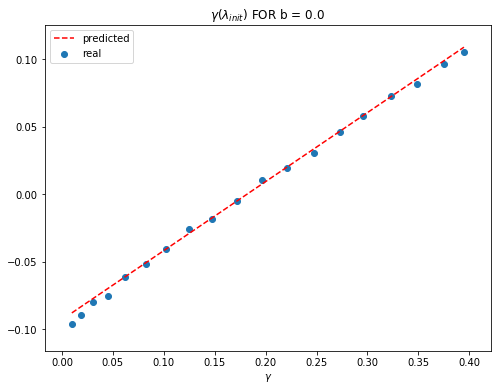

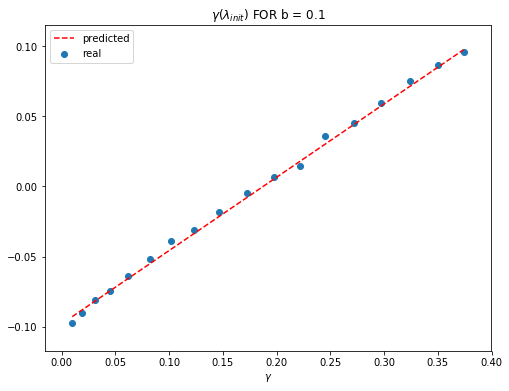

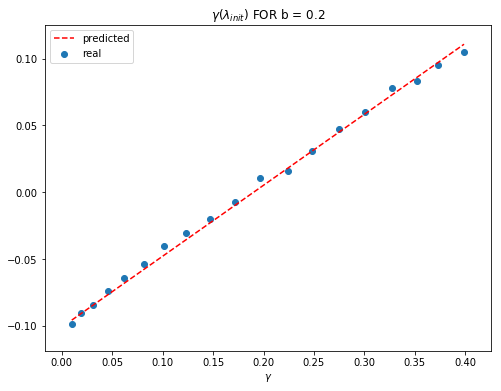

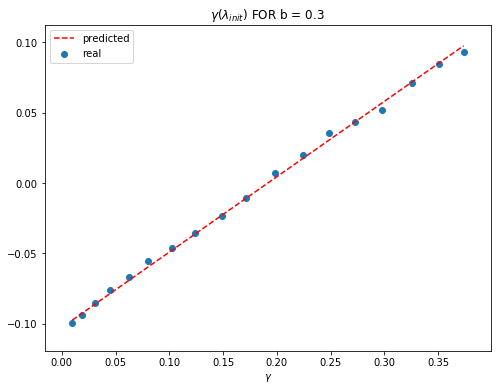

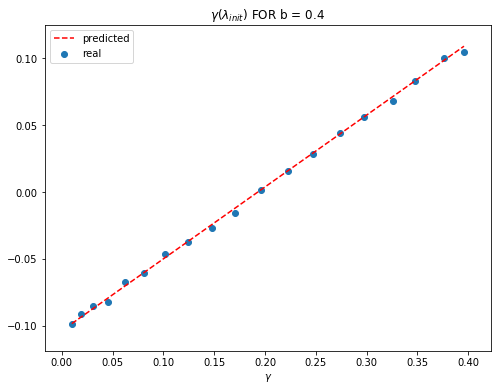

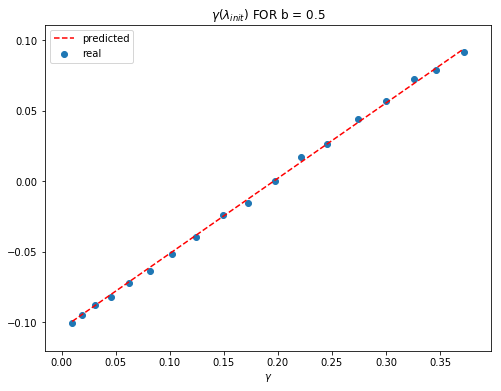

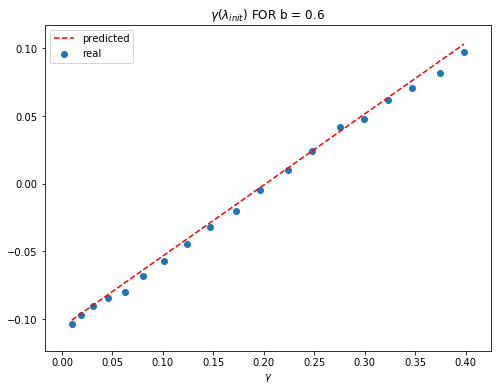

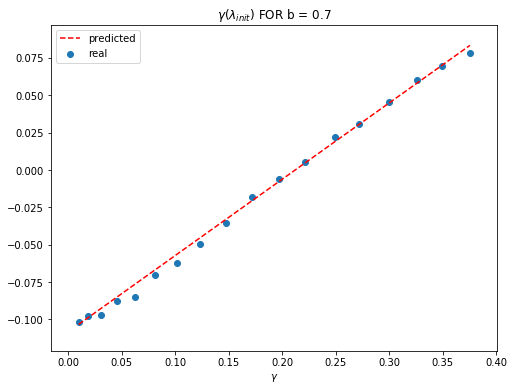

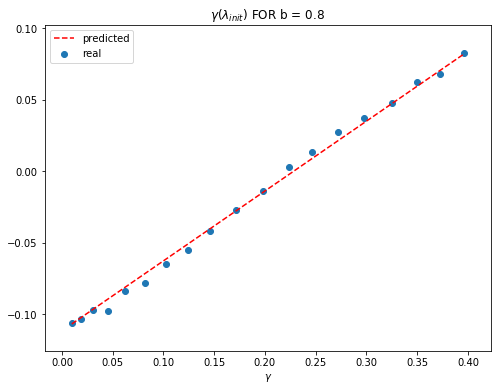

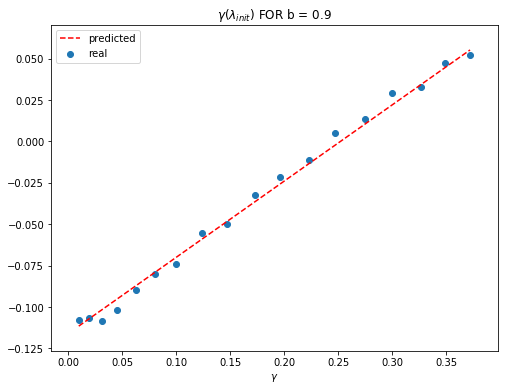

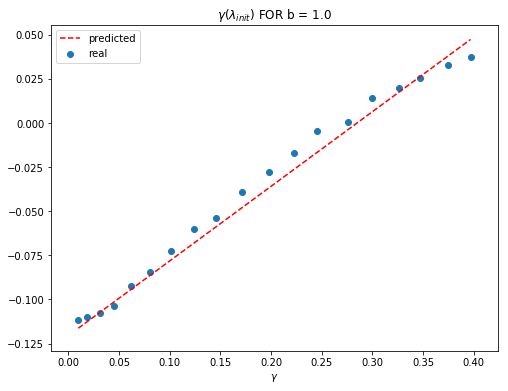

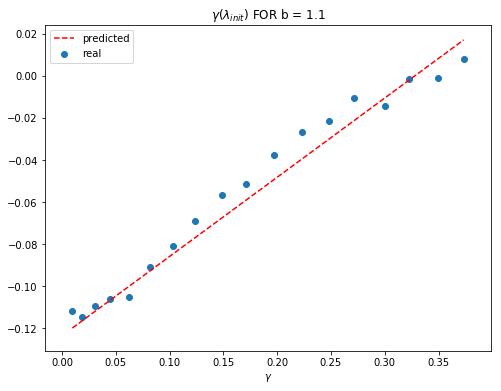

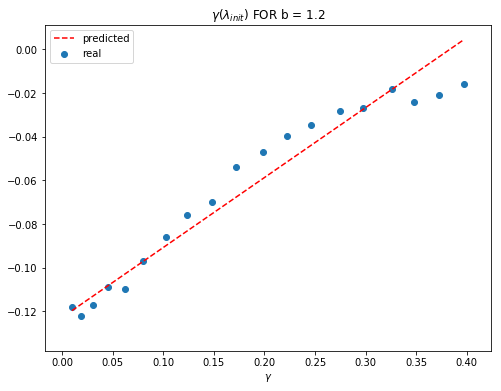

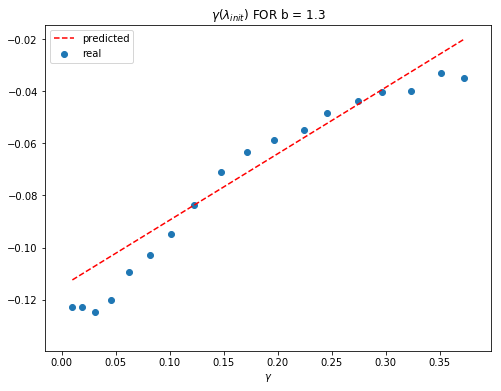

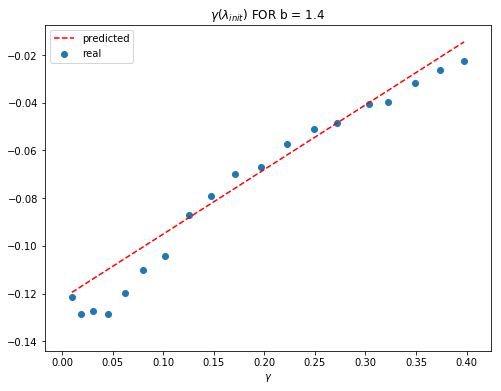

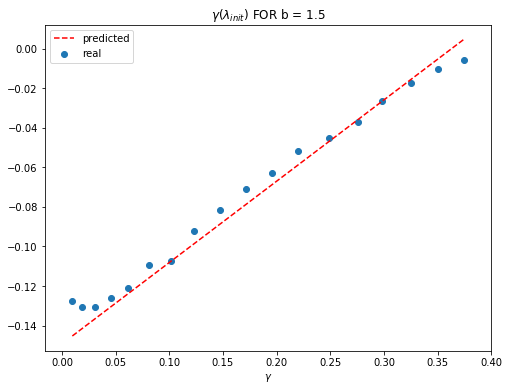

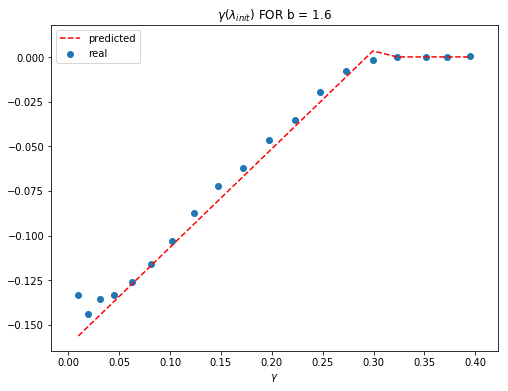

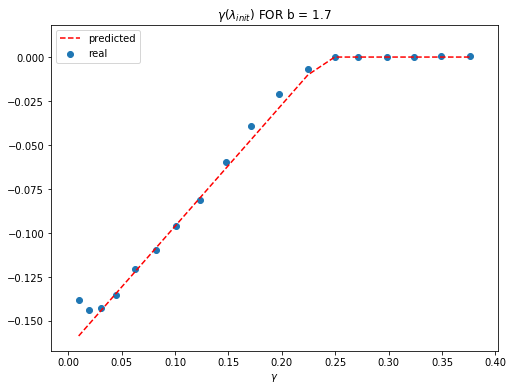

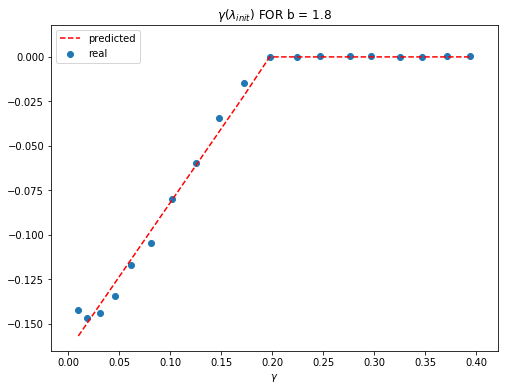

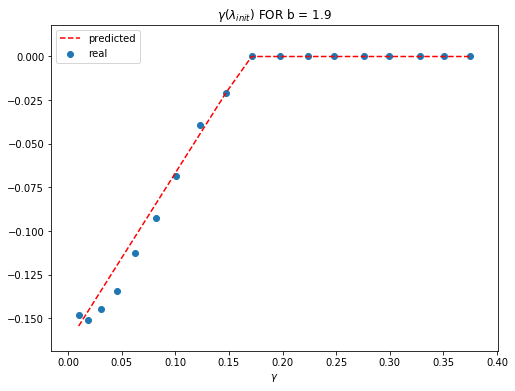

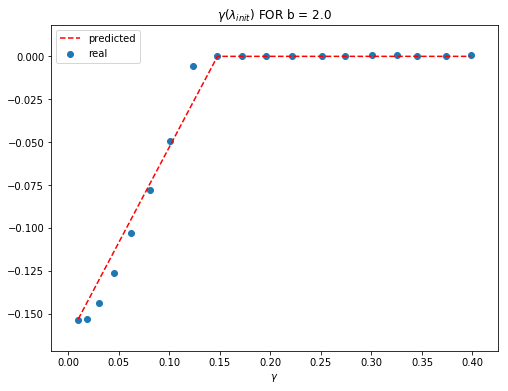

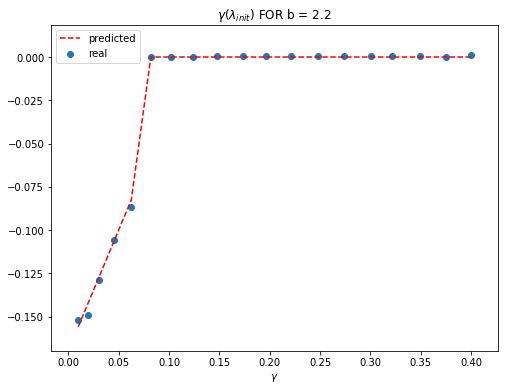

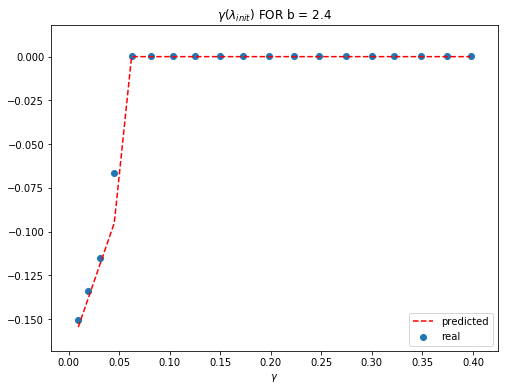

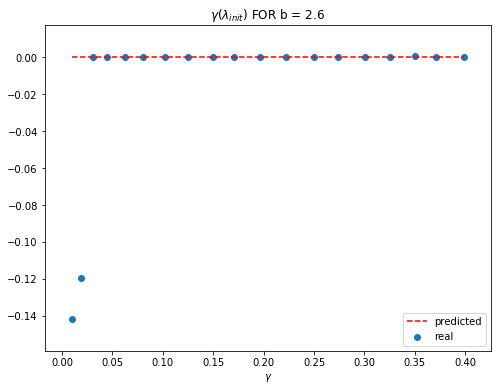

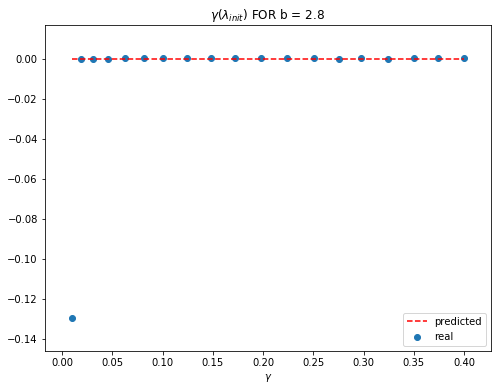

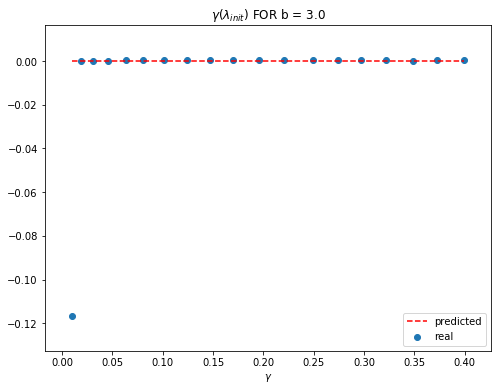

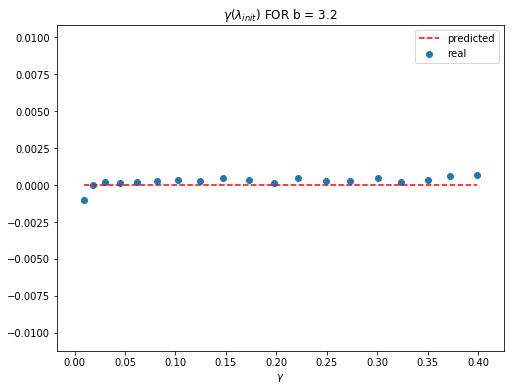

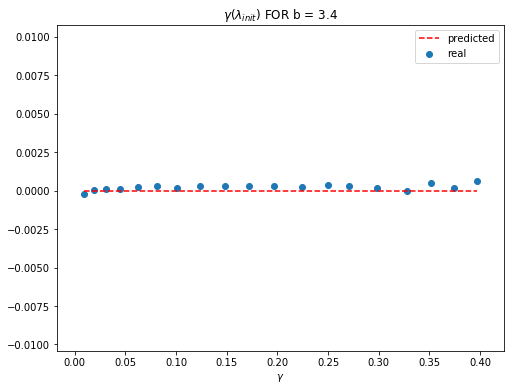

In [417]:
for b in sorted(result_b.keys()):
    x = result_b[b]["l1"]
    arr = result_b[b]["l1"] - result_b[b]["l2"]
    gamm = []
    
    for el in x:
        gamm.append(gamma(float(b),el))
        
    plt.figure(figsize=(8,6))
    plt.scatter(x,arr, label = "real")
    plt.plot(x,gamm, '--r', label = "predicted")
    plt.legend()
    plt.xlabel("$\lambda_{init}$")
    plt.xlabel("$\gamma$")
    plt.title("$\gamma (\lambda_{init})$ FOR b = %0.1lf"%(float(b)))
    plt.show()